# <div class="alert alert-info"> 1. ARIMA </div>

## <font color=red>1.1. Introduction</font>

The general process for ARIMA model is the following:
+ Visualize the time series data
+ Make the time series data stationary
+ Plot the Correlation and AutoCorrelation Charts
+ Construct the ARIMA Model
+ Use the model to make predictions

---
# <div class="alert alert-info"> 2. Setup </div>

 ## <font color=red>2.1. Import library</font>

In [1]:
import quandl
import warnings
import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import the models we'll be using in this section
from statsmodels.tsa.stattools import ccovf,ccf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.model_selection import TimeSeriesSplit

 ## <font color=red>2.2. Configuration</font>

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 505)

---
# <div class="alert alert-info"> 3. Data Preparation </div>

 ## <font color=red>3.1.  Load data</font>

In [3]:
df = pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)
df.index.freq = 'MS'
print(df.shape)
df.head()

(144, 1)


,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


---
# <div class="alert alert-info"> 4. Preliminary Analysis </div>

To explore the dataset:
+ Are there consisten patterns?
+ Is there a significant trend?
+ Is seasonality important?
+ Is there evidence of the presence of business cycles?
+ Are there any outliers in the data that need to be explained by those with expert knowledge?

 ## <font color=red>4.1. Time-series plots</font>

In [5]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags = None, figsize=(12,8), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

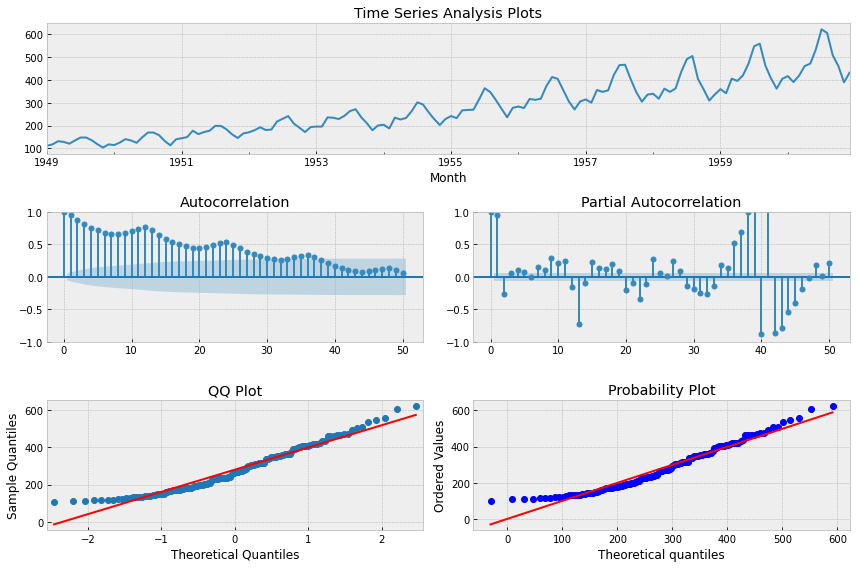

In [6]:
tsplot(df['Thousands of Passengers'], lags=50)

 ## <font color=red>4.2. Examine stationary</font>

In [139]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
        
from statsmodels.tsa.stattools import adfuller, acf, pacf
def check_stationarity(timeseries, k):
    # Determing rolling statistics
    rolling_mean = timeseries.rolling(window=k, center=False).mean()
    rolling_std = timeseries.rolling(window = k, center = False).std()
        
    # Plot rolling statistics
    plt.figure(figsize=(16,7))
    plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color ='blue', label = 'Original')
    plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    adf_test(timeseries,title='')

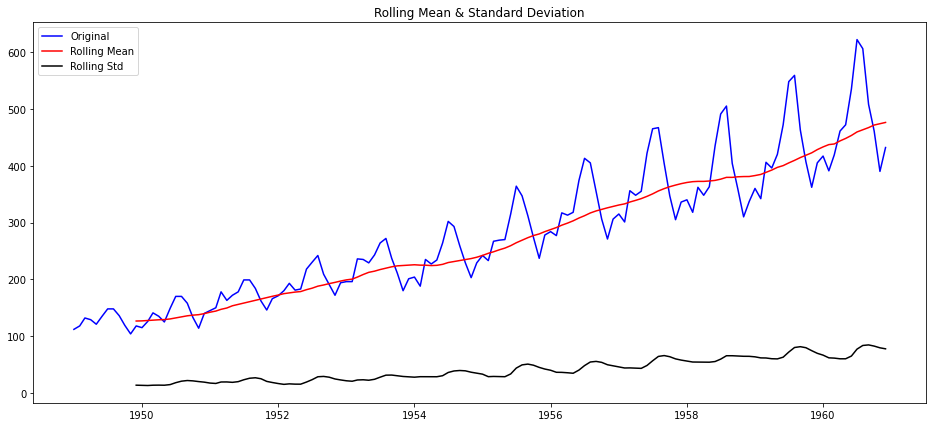

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [140]:
check_stationarity(df['Thousands of Passengers'], 12)

---
# <div class="alert alert-info"> 5. Build ARIMA model </div>

## <font color=red> 5.1. Introduction
    
<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of AR model and MA model with a differenced series:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. It is the correlation a current time series with a lagged version of the same series.

    
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary. We apply differencing to make a time series stationary, which ARIMA requires.

    
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. Can be found using SMA, EWMA or Holt-Winters Method
    
Thus, for a stationary time series ARIMA models combine autoregression and moving average concepts to model the behavior of a long running time series and helps in forecasting.

**Example**:
Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

## <font color=red> 5.2. ARIMA

### <font color=blue> 1. Split data

In [459]:
ts_data = df['Thousands of Passengers']
# split data into 2 sets: train set and test set
size = int(len(ts_data) - 25)
train, test = ts_data[0:size], ts_data[size:len(ts_data.values)]

### <font color=blue> 2. Train the model

In [464]:
model = sm.tsa.ARIMA(train, order=(12,2,1))
results_ARIMA = model.fit()

### <font color=blue>3. Print the results of the ARIMA model

In [465]:
print(results_ARIMA.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Thousands of Passengers   No. Observations:                  119
Model:                     ARIMA(12, 2, 1)   Log Likelihood                -447.296
Date:                     Sun, 11 Sep 2022   AIC                            922.592
Time:                             20:59:37   BIC                            961.263
Sample:                         01-01-1949   HQIC                           938.292
                              - 11-01-1958                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1305      0.104     -1.253      0.210      -0.335       0.074
ar.L2         -0.1710      0.096     -1.781      0.075      -0.359       0.017
ar.L3       

### <font color=blue> 4. Plot results on train set

[]

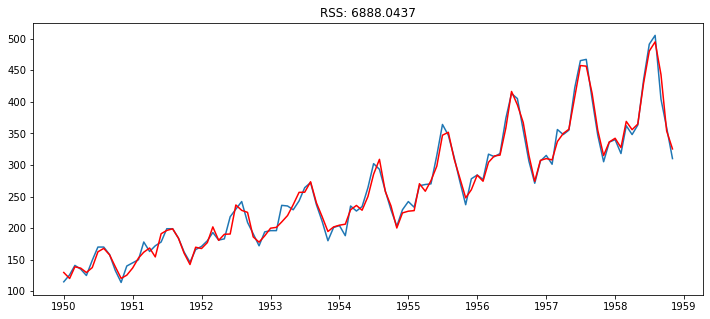

In [466]:
plt.figure(figsize=(12,5))
plt.plot(train.index[12:].to_pydatetime(), train.values[12:])
plt.plot(train.index[12:].to_pydatetime(), results_ARIMA.fittedvalues[12:], color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues[12:] - train.values[12:]) ** 2)
plt.plot()

#### Plot residual errors

                0
count  119.000000
mean     1.040578
std     15.453915
min    -50.008362
25%     -6.899703
50%     -0.285432
75%      7.379081
max    112.000000


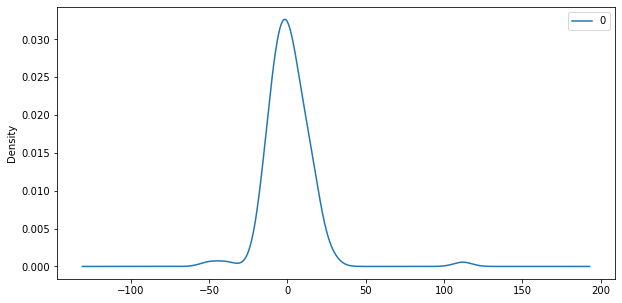

In [467]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde', figsize=(10,5))
print(residuals.describe())

### <font color=blue> 5. Perform and visualize test set

In [468]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(12,2,2) Predictions')

In [469]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=341.1147431330102, expected=337
predicted=346.92951816833437, expected=360
predicted=326.1318178548929, expected=342
predicted=369.96888200544197, expected=406
predicted=355.2267846533251, expected=396
predicted=379.99461138719795, expected=420
predicted=448.280525666891, expected=472
predicted=507.5692967589864, expected=548
predicted=520.0992836658045, expected=559
predicted=427.6604716266836, expected=463
predicted=384.9229588058263, expected=407
predicted=341.62387476021166, expected=362
predicted=369.79571256981365, expected=405
predicted=372.45289726066, expected=417
predicted=350.90444177294216, expected=391
predicted=390.6984597939219, expected=419
predicted=374.6612419486135, expected=461
predicted=405.1206808666034, expected=472
predicted=469.43799191288684, expected=535
predicted=529.6042750271287, expected=622
predicted=540.5772161513374, expected=606
predicted=454.77308909611884, expected=508
predicted=414.56463451938646, expected=461
predicted=375.2758811108086,

[]

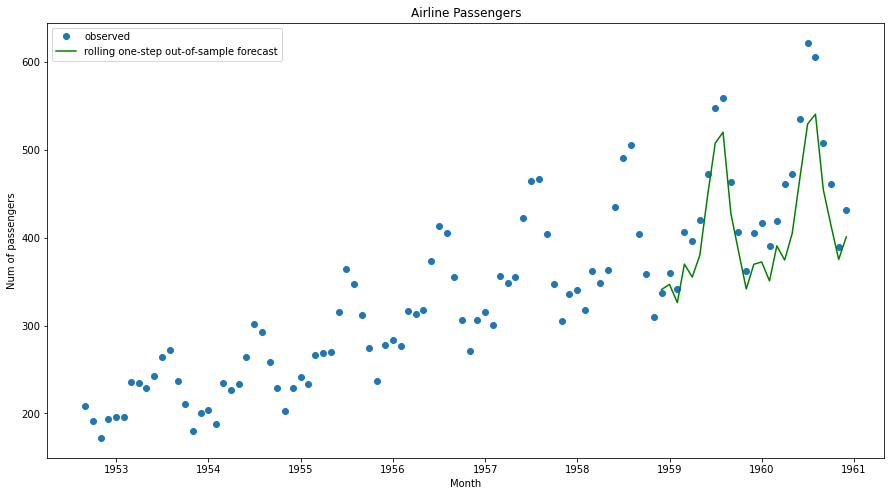

In [470]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

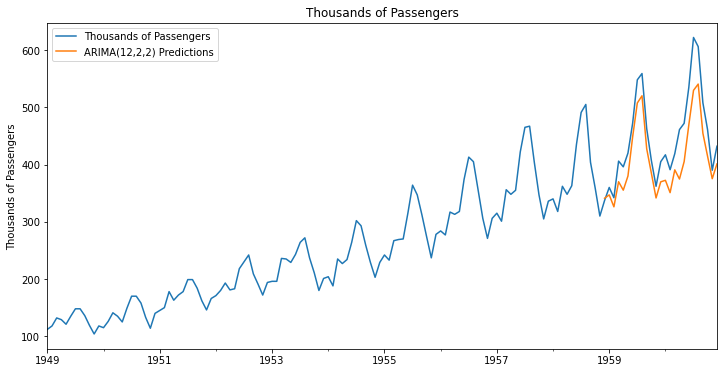

In [471]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue>6. Evaluate the Model

In [472]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 2068.212391


In [473]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 45.47760318


### <font color=blue>7. Continously retrain model

In [478]:
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = sm.tsa.ARIMA(historical, order=(12,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted value = %f, Expected value = %f' % (yhat, observed))

Printing Predicted vs Expected Values...


Predicted value = 341.114743, Expected value = 337.000000
Predicted value = 346.044577, Expected value = 360.000000
Predicted value = 337.538997, Expected value = 342.000000
Predicted value = 383.435504, Expected value = 406.000000
Predicted value = 386.569174, Expected value = 396.000000
Predicted value = 410.740729, Expected value = 420.000000
Predicted value = 484.310139, Expected value = 472.000000
Predicted value = 523.301954, Expected value = 548.000000
Predicted value = 556.176181, Expected value = 559.000000
Predicted value = 458.373641, Expected value = 463.000000
Predicted value = 415.081675, Expected value = 407.000000
Predicted value = 353.450851, Expected value = 362.000000
Predicted value = 388.698271, Expected value = 405.000000
Predicted value = 416.513546, Expected value = 417.000000
Predicted value = 399.588737, Expected value = 391.000000
Predicted value = 443.132294, Expected value = 419.000000
Predicted value = 414.570873,

300.77026534345526


[]

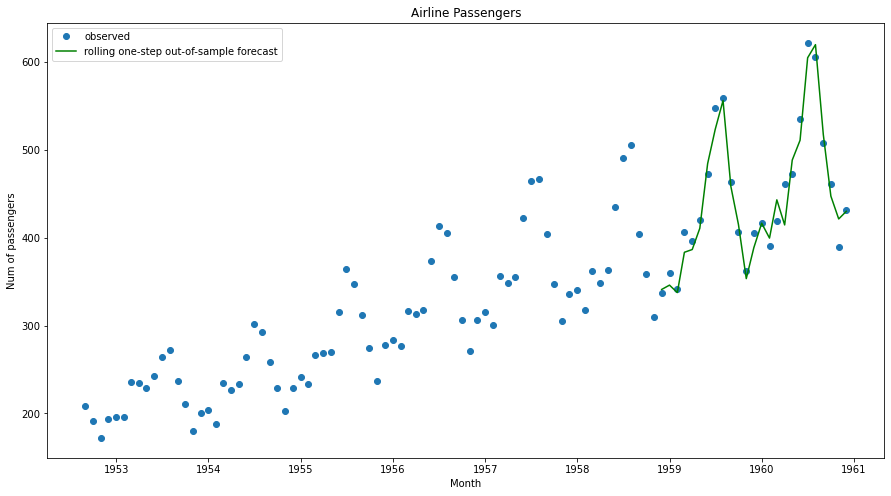

In [479]:
# calculate error
from sklearn.metrics import mean_squared_error    
error = mean_squared_error(test, predictions)
print(error)

# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

In [481]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions_series)
print(f'ARIMA(12,2,1) MSE Error: {error:11.10}')

ARIMA(12,2,1) MSE Error: 300.7702653


In [482]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions_series)
print(f'ARIMA(12,2,1) RMSE Error: {error:11.10}')

ARIMA(12,2,1) RMSE Error: 17.34272947


### <font color=blue>8. Retrain the model on the full data, and forecast the future

In [492]:
model = sm.tsa.ARIMA(ts_data,order=(12,2,2))
results = model.fit()
fcast = results.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('ARIMA(12,2,2) Forecast')

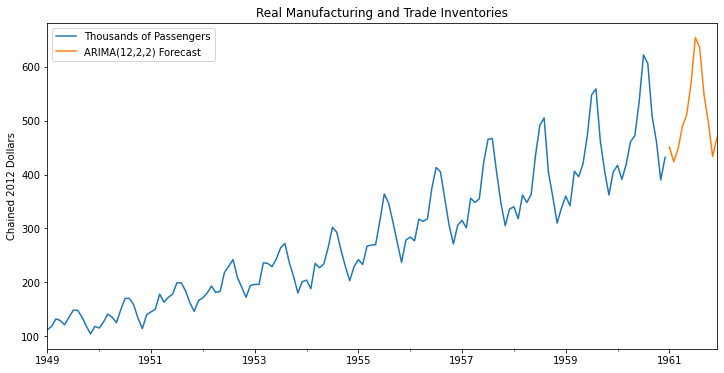

In [493]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## <font color=red> 6.2. SARIMA

### <font color=blue>1. Using auto arima to estimate p,d,q

In [495]:
from pmdarima import auto_arima    
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(train,seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  119
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -396.839
Date:                            Sun, 11 Sep 2022   AIC                            801.679
Time:                                    21:17:35   BIC                            812.370
Sample:                                         0   HQIC                           806.013
                                            - 119                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5597      2.054      2.220      0.026       0.533       8.586
ar.L1          0.6701      0.100      6.694      0.000       0.474       0.866
ar.L2          0.1562      0.097      1.614      0.106      -0.033       0.346
sigma2        96.5155     11.915      8.101      0.000      73.163     119.868
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.92   Prob(JB):                         0.45
Heteroskedasticity (H):               1.47   Skew:                             0.00
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <font color=blue>2. Train SARIMA

In [529]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(train,order=(2,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  119
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -396.127
Date:                            Sun, 11 Sep 2022   AIC                            798.255
Time:                                    21:31:16   BIC                            806.245
Sample:                                01-01-1949   HQIC                           801.493
                                     - 11-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2317      0.092     -2.530      0.011      -0.411      -0.052
ar.L2          0.0475      0.116   

### <font color=blue> 3. Prediction of Future Values

Firts we can get an idea of how well our model performs by just predicting for values that we actually already know:

In [530]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [531]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=343.1912885451326, expected=337
predicted=346.3513952714295, expected=360
predicted=324.6499796724776, expected=342
predicted=368.54094266042136, expected=406
predicted=354.5803750586411, expected=396
predicted=369.566064507003, expected=420
predicted=441.571251421935, expected=472
predicted=497.56937054428505, expected=548
predicted=511.5700524749827, expected=559
predicted=410.569805219558, expected=463
predicted=365.56989486786017, expected=407
predicted=316.56986236349536, expected=362
predicted=349.76116269391264, expected=405
predicted=352.9212651471503, expected=417
predicted=331.21985109750585, expected=391
predicted=375.1108135237083, expected=419
predicted=361.15024612560177, expected=461
predicted=376.1359355001165, expected=472
predicted=448.1411224418237, expected=535
predicted=504.1392415544656, expected=622
predicted=518.139923488683, expected=606
predicted=417.13967623198215, expected=508
predicted=372.139765880747, expected=461
predicted=323.13973337621445, e

[]

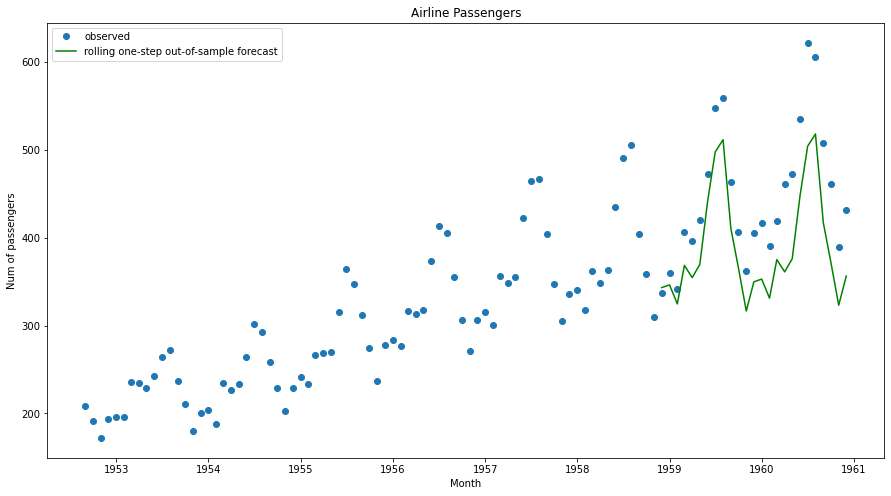

In [532]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

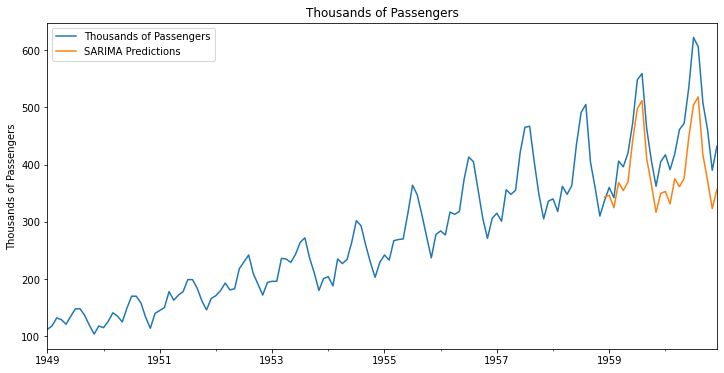

In [533]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue> 4. Evaluate the Model

In [534]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 4230.243885


In [535]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 65.04032507


### <font color=blue>5. Retrain the model on the full data, and forecast the future

In [536]:
model = sm.tsa.statespace.SARIMAX(ts_data,order=(1,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
fcast = results.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('SARIMA Forecast')

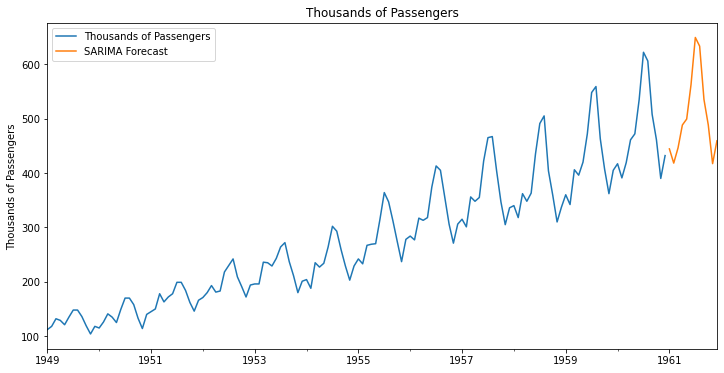

In [537]:
# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel=''

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## <font color=red> 6.3. ARIMA with second order differencing

### <font color=blue> 1. Calculate second order differencing

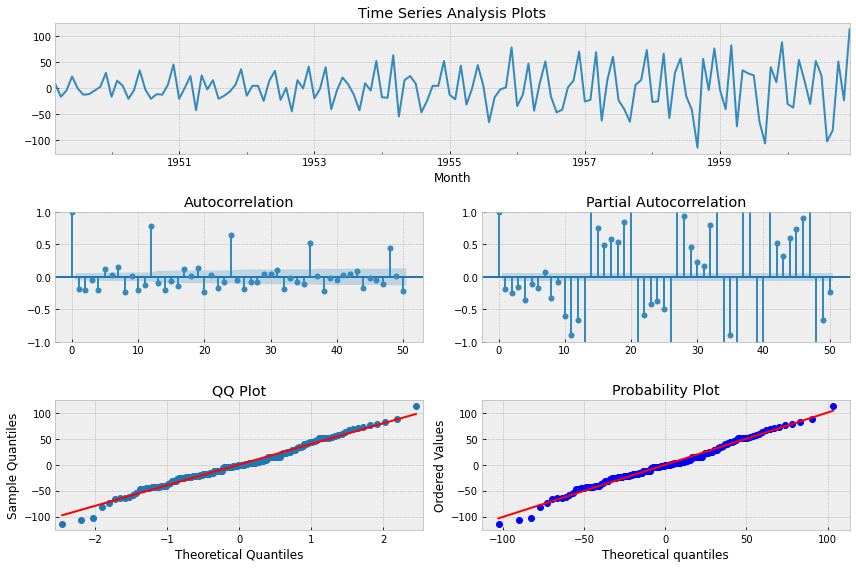

In [538]:
ts_data = df['Thousands of Passengers'].diff().diff()
#ts_data.dropna(inplace=True)

tsplot(ts_data.dropna(), lags=50)

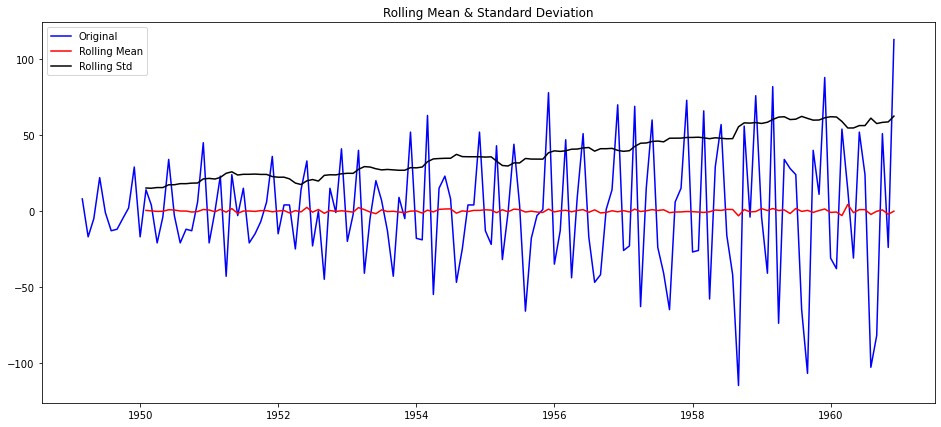

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.638423e+01
p-value                 2.732892e-29
# lags used             1.100000e+01
# observations          1.300000e+02
critical value (1%)    -3.481682e+00
critical value (5%)    -2.884042e+00
critical value (10%)   -2.578770e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [539]:
check_stationarity(ts_data.dropna(), 12)

### <font color=blue> 2. Split time series data

In [540]:
# split data into 2 sets: train set and test set
size = int(len(ts_data) - 25)
train, test = ts_data[0:size], ts_data[size:len(ts_data.values)]
size

119

### <font color=blue> 3. Train the model

In [542]:
#model = sm.tsa.ARIMA(train, order=(12,1,1))
model = sm.tsa.statespace.SARIMAX(train,order=(1,0,1), seasonal_order=(0,1,0,12))
results_ARIMA = model.fit()

### <font color=blue>2. Print the results of the ARIMA model

In [543]:
print(results_ARIMA.summary())

                                      SARIMAX Results                                      
Dep. Variable:             Thousands of Passengers   No. Observations:                  119
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                -411.205
Date:                             Sun, 11 Sep 2022   AIC                            828.411
Time:                                     21:32:37   BIC                            836.429
Sample:                                 01-01-1949   HQIC                           831.661
                                      - 11-01-1958                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2359      0.094     -2.513      0.012      -0.420      -0.052
ma.L1         -0.9996      

### <font color=blue> 3. Plot results

[]

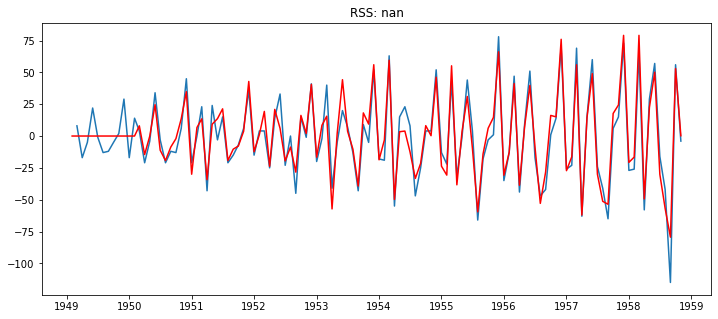

In [544]:
plt.figure(figsize=(12,5))
plt.plot(train.index[1:].to_pydatetime(), train.values[1:])
plt.plot(train.index[1:].to_pydatetime(), results_ARIMA.fittedvalues[1:], color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues[1:] - train.values[1:]) ** 2)
plt.plot()

#### Plot residual errors

                0
count  117.000000
mean    -0.814761
std     10.884959
min    -35.552007
25%     -6.939887
50%     -2.976509
75%      6.620351
max     29.000449


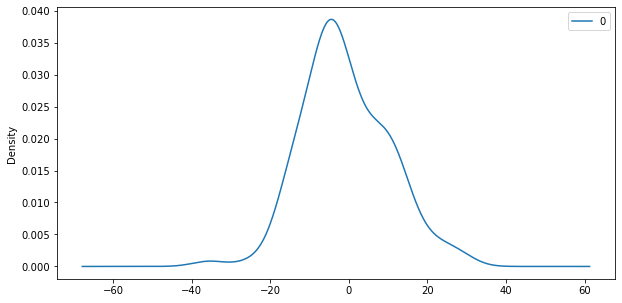

In [545]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde', figsize=(10,5))
print(residuals.describe())

### <font color=blue> 4. Perform and visualize test set

In [546]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,1) Predictions')
predictions.head()

1958-12-01    81.678625
1959-01-01   -29.046961
1959-02-01   -25.517199
1959-03-01    65.886125
1959-04-01   -57.973141
Freq: MS, Name: ARIMA(1,0,1) Predictions, dtype: float64

[]

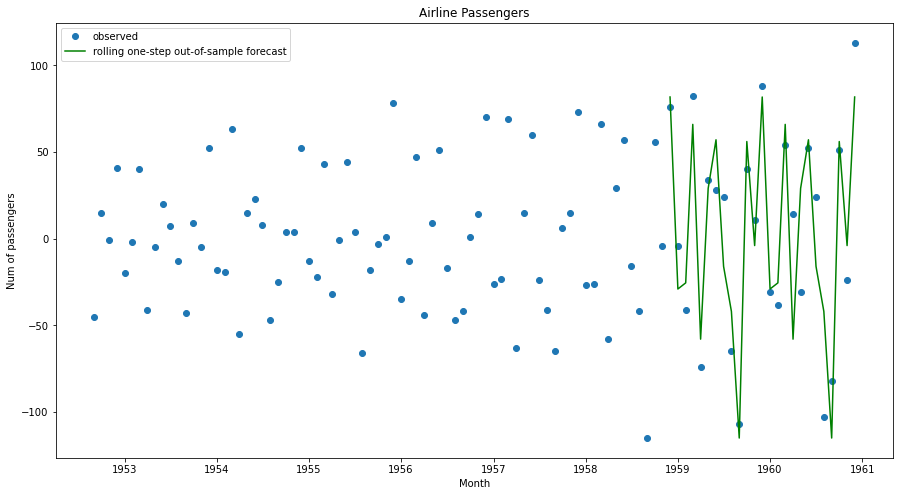

In [547]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

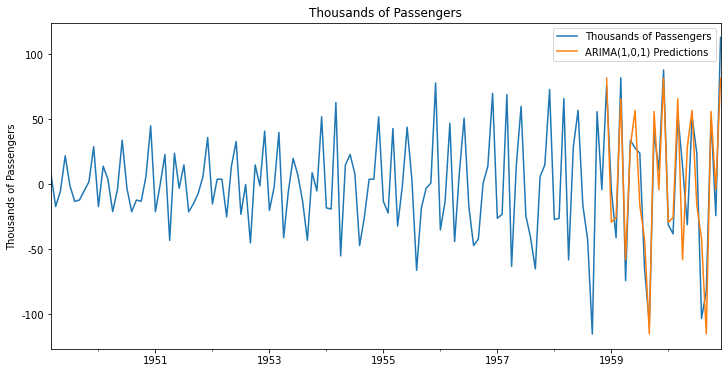

In [548]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [549]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=81.67862467933558, expected=76.0
predicted=-29.046960756500486, expected=-4.0
predicted=-25.517199038618433, expected=-41.0
predicted=65.88612543373354, expected=82.0
predicted=-57.97314127791861, expected=-74.0
predicted=28.99366503886252, expected=34.0
predicted=57.001494178780796, expected=28.0
predicted=-16.000352420509063, expected=24.0
predicted=-41.99991687727278, expected=-65.0
predicted=-115.00001960552125, expected=-107.0
predicted=56.00000462420419, expected=40.0
predicted=-4.000001090675638, expected=11.0
predicted=81.6786249365849, expected=88.0
predicted=-29.04696081717591, expected=-31.0
predicted=-25.517199024307384, expected=-38.0
predicted=65.8861254303581, expected=54.0
predicted=-57.973141277122465, expected=14.0
predicted=28.99366503867474, expected=-31.0
predicted=57.001494178825084, expected=52.0
predicted=-16.00035242051951, expected=24.0
predicted=-41.999916877270316, expected=-103.0
predicted=-115.00001960552183, expected=-82.0
predicted=56.000004624

In [550]:
first_diff = (df['Thousands of Passengers'][size-1] - df['Thousands of Passengers'][size-2]) + predictions.cumsum()
converted_prediction = df['Thousands of Passengers'][size-1] + first_diff.cumsum()

In [551]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df['Thousands of Passengers'][size-2],df['Thousands of Passengers'][size-1]

# Apply the formula
for i in predictions:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

In [552]:
df['prediction'] = converted_prediction
df[size:].head()

,Thousands of Passengers,prediction,predictions
Month,,,
1958-12-01,337,342.678625,342.795362
1959-01-01,360,346.310289,357.310126
1959-02-01,342,324.424753,326.624754
1959-03-01,406,368.425344,355.541023
1959-04-01,396,354.452793,302.330660


[]

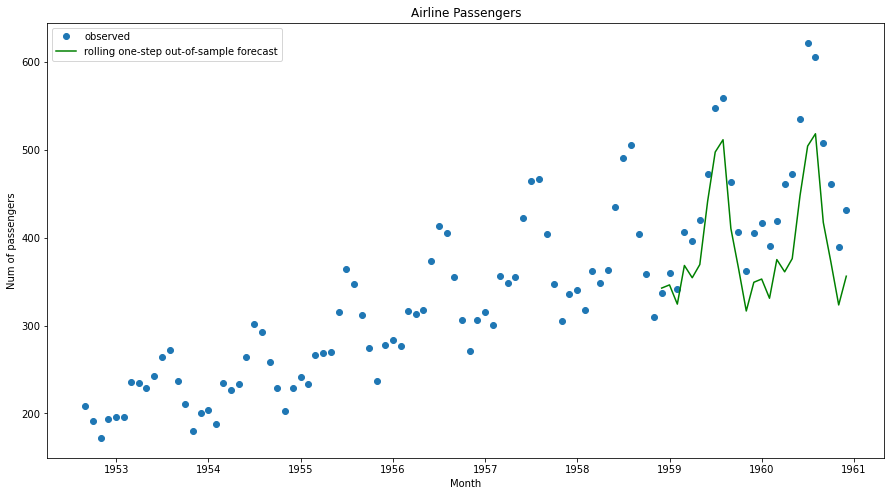

In [553]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(df['Thousands of Passengers'][-100:], 'o', label='observed')
ax.plot(converted_prediction, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

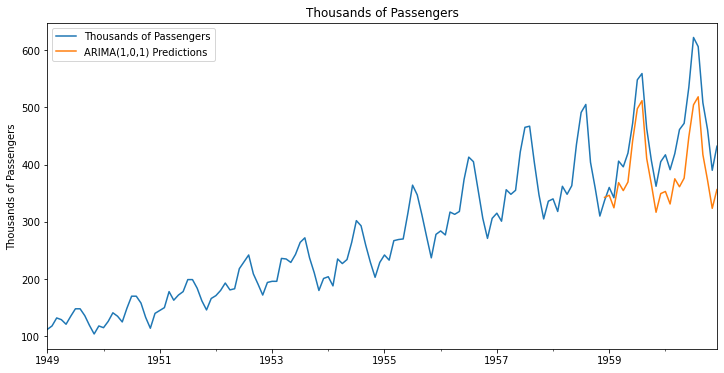

In [554]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
converted_prediction.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue>5. Evaluate the Model

In [555]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 876.6937732


In [556]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(df['Thousands of Passengers'][size:].values, df['prediction'][size:].values)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 4224.430967


In [557]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 29.60901507


In [558]:
from sklearn.metrics import mean_squared_error

error = rmse(df['Thousands of Passengers'][size:].values, df['prediction'][size:].values)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 64.99562268


### <font color=blue>6. Retrain the model on the full data, and forecast the future

In [559]:
fcast = results_ARIMA.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('ARIMA(12,0,1) Forecast')
first_diff = (df['Thousands of Passengers'][-1] - df['Thousands of Passengers'][-2]) + fcast.cumsum()
converted_fcast = df['Thousands of Passengers'][-1] + first_diff.cumsum()

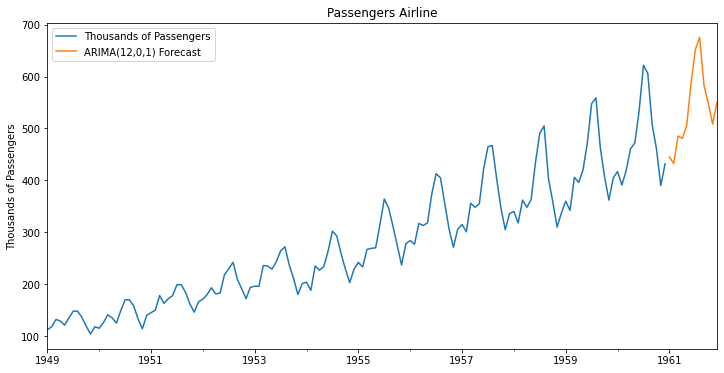

In [560]:
# Plot predictions against known values
title = 'Passengers Airline'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
converted_fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);